In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob


## Get image data, count types, construct training data

In [2]:
REBUILD_DATA = True

class IMGproc():
    #we can reduce the size of the image to try and reduce the amount of data per image
    img_size = 100
    
    #dictionary of labels and values
    labels = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'mel': 5, 'vasc': 6}
    
    training_data = []
    akiec_count = 0
    bcc_count = 0
    bkl_count = 0
    df_count = 0
    nv_count = 0
    mel_count = 0
    vasc_count = 0
    
    #look up and load image files and labels based on metadata
    def make_training_data(self):
        ham_meta = pd.read_csv('HAM10000_metadata.csv')
        image_files_1 = glob.glob('HAM10000_images_part_1/*')
        image_files_2 = glob.glob('HAM10000_images_part_2/*')
        image_files = np.concatenate((np.array(image_files_1), np.array(image_files_2)), axis=0)
        
        #if we want to limit the number of images so that all images have the same amount
        count_limit = 99999 
        #loop through image files
        for i in tqdm(range(len(image_files))):
            
            try:
                #get image name
                img_name = image_files[i].split('/')[1][:-4]
                #check image name with image_id
                img_dex = np.where(ham_meta['image_id'].values == img_name)[0][0]
                #check cancer type
                dx_type = ham_meta['dx'][img_dex]
                #check if cancer type has reached limit
                if dx_type == 'akiec':
                    if self.akiec_count >= count_limit:
                        continue
                if dx_type == 'bcc':
                    if self.bcc_count >= count_limit:
                        continue
                if dx_type == 'bkl':
                    if self.bkl_count >= count_limit:
                        continue
                if dx_type == 'df':
                    if self.df_count >= count_limit:
                        continue
                if dx_type == 'nv':
                    if self.nv_count >= count_limit:
                        continue
                if dx_type == 'mel':
                    if self.mel_count >= count_limit:
                        continue
                if dx_type == 'vasc':
                    if self.vasc_count >= count_limit:
                        continue
                #Load image in grayscale
                img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
                #Reduce image size
                img = cv2.resize(img, (self.img_size, self.img_size))
                #Add to training data
                self.training_data.append([np.array(img), np.eye(7)[self.labels[dx_type]]])

                if dx_type == 'akiec':
                    self.akiec_count += 1
                elif dx_type == 'bcc':
                    self.bcc_count += 1
                elif dx_type == 'bkl':
                    self.bkl_count += 1
                elif dx_type == 'df':
                    self.df_count += 1
                elif dx_type == 'nv':
                    self.nv_count += 1
                elif dx_type == 'mel':
                    self.mel_count += 1
                elif dx_type == 'vasc':
                    self.vasc_count += 1
            except Exception as e:
                print(str(e))
            
        #Shuffle training data
        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('akiec:', self.akiec_count)
        print('bcc:', self.bcc_count)
        print('bkl:', self.bkl_count)
        print('df:', self.df_count)
        print('nv:', self.nv_count)
        print('mel:', self.mel_count)
        print('vasc:', self.vasc_count)
        
if REBUILD_DATA:
    img_proc = IMGproc()
    img_proc.make_training_data()
    

100%|██████████| 10015/10015 [01:50<00:00, 91.02it/s] 
/Users/georgevejar/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


akiec: 327
bcc: 514
bkl: 1099
df: 115
nv: 6705
mel: 1113
vasc: 142


## Check data

In [3]:
training_data = np.load('training_data.npy', allow_pickle=True)

In [4]:
print(len(training_data))

10015


In [5]:
print(len(training_data[0][0]))

100


In [6]:
print(training_data[1])

[array([[178, 173, 169, ..., 201, 201, 195],
        [176, 176, 173, ..., 194, 198, 185],
        [171, 174, 175, ..., 193, 189, 189],
        ...,
        [176, 176, 179, ..., 183, 178, 170],
        [111, 112, 117, ..., 182, 178, 179],
        [114, 121, 123, ..., 186, 188, 187]], dtype=uint8)
 array([0., 0., 0., 0., 1., 0., 0.])]


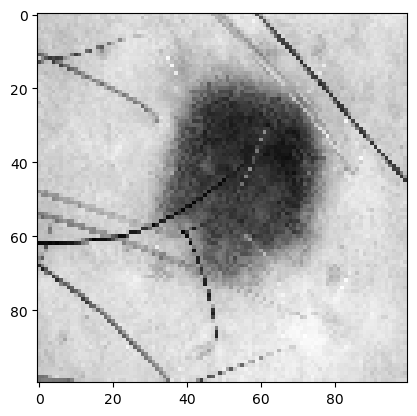

In [7]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0], cmap = 'gray')
plt.show()

## Create Neural Net

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolutional layers
        self.conv1 = nn.Conv2d(1,32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32,64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64,128, 5)
        
        #test data
        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        #linear fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening
        self.fc2 = nn.Linear(512, 7) # 512 in, 7 out bc we're doing 7 classes
        
    def convs(self, x):
        #max pooling and relu
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # .view is reshape ... this flattens X before
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

torch.Size([128, 9, 9])
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


In [9]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 100,100)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

<ipython-input-9-c6d93239015f>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 100,100)


1001


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

9014
1001


In [11]:
BATCH_SIZE = 10
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time.
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 100,100)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        #print(len(outputs), len(batch_y))
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() # Does the update
        
print(loss)

  0%|          | 0/902 [00:00<?, ?it/s]

torch.Size([128, 9, 9])


  0%|          | 2/902 [00:00<04:42,  3.19it/s]

torch.Size([128, 9, 9])


  0%|          | 3/902 [00:00<04:07,  3.64it/s]

torch.Size([128, 9, 9])


  0%|          | 4/902 [00:01<03:57,  3.78it/s]

torch.Size([128, 9, 9])


  1%|          | 5/902 [00:01<03:50,  3.89it/s]

torch.Size([128, 9, 9])


  1%|          | 6/902 [00:01<03:46,  3.96it/s]

torch.Size([128, 9, 9])


  1%|          | 7/902 [00:01<03:36,  4.12it/s]

torch.Size([128, 9, 9])


  1%|          | 8/902 [00:02<03:29,  4.26it/s]

torch.Size([128, 9, 9])


  1%|          | 9/902 [00:02<03:29,  4.26it/s]

torch.Size([128, 9, 9])


  1%|          | 10/902 [00:02<03:29,  4.25it/s]

torch.Size([128, 9, 9])


  1%|          | 11/902 [00:02<03:29,  4.25it/s]

torch.Size([128, 9, 9])


  1%|▏         | 12/902 [00:03<03:30,  4.24it/s]

torch.Size([128, 9, 9])


  1%|▏         | 13/902 [00:03<03:29,  4.25it/s]

torch.Size([128, 9, 9])


  2%|▏         | 14/902 [00:03<03:29,  4.23it/s]

torch.Size([128, 9, 9])


  2%|▏         | 15/902 [00:03<03:40,  4.02it/s]

torch.Size([128, 9, 9])


  2%|▏         | 16/902 [00:04<03:55,  3.76it/s]

torch.Size([128, 9, 9])


  2%|▏         | 17/902 [00:04<03:55,  3.76it/s]

torch.Size([128, 9, 9])


  2%|▏         | 18/902 [00:04<04:09,  3.54it/s]

torch.Size([128, 9, 9])


  2%|▏         | 19/902 [00:04<03:53,  3.78it/s]

torch.Size([128, 9, 9])


  2%|▏         | 20/902 [00:05<03:46,  3.89it/s]

torch.Size([128, 9, 9])


  2%|▏         | 21/902 [00:05<03:46,  3.89it/s]

torch.Size([128, 9, 9])


  2%|▏         | 22/902 [00:05<03:42,  3.96it/s]

torch.Size([128, 9, 9])


  3%|▎         | 23/902 [00:05<03:41,  3.96it/s]

torch.Size([128, 9, 9])


  3%|▎         | 24/902 [00:06<03:46,  3.87it/s]

torch.Size([128, 9, 9])


  3%|▎         | 25/902 [00:06<03:42,  3.93it/s]

torch.Size([128, 9, 9])


  3%|▎         | 26/902 [00:06<03:35,  4.06it/s]

torch.Size([128, 9, 9])


  3%|▎         | 27/902 [00:06<03:33,  4.09it/s]

torch.Size([128, 9, 9])


  3%|▎         | 28/902 [00:07<03:36,  4.04it/s]

torch.Size([128, 9, 9])


  3%|▎         | 29/902 [00:07<03:35,  4.05it/s]

torch.Size([128, 9, 9])


  3%|▎         | 30/902 [00:07<03:31,  4.13it/s]

torch.Size([128, 9, 9])


  3%|▎         | 31/902 [00:07<03:26,  4.21it/s]

torch.Size([128, 9, 9])


  4%|▎         | 32/902 [00:08<03:18,  4.39it/s]

torch.Size([128, 9, 9])


  4%|▎         | 33/902 [00:08<03:15,  4.44it/s]

torch.Size([128, 9, 9])


  4%|▍         | 34/902 [00:08<03:17,  4.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  4%|▍         | 36/902 [00:09<03:36,  4.00it/s]

torch.Size([128, 9, 9])


  4%|▍         | 37/902 [00:09<03:25,  4.21it/s]

torch.Size([128, 9, 9])


  4%|▍         | 38/902 [00:09<03:16,  4.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  4%|▍         | 40/902 [00:09<03:13,  4.45it/s]

torch.Size([128, 9, 9])


  5%|▍         | 41/902 [00:10<03:20,  4.30it/s]

torch.Size([128, 9, 9])


  5%|▍         | 42/902 [00:10<03:20,  4.30it/s]

torch.Size([128, 9, 9])


  5%|▍         | 43/902 [00:10<03:25,  4.18it/s]

torch.Size([128, 9, 9])


  5%|▍         | 44/902 [00:10<03:24,  4.20it/s]

torch.Size([128, 9, 9])


  5%|▍         | 45/902 [00:11<03:18,  4.32it/s]

torch.Size([128, 9, 9])


  5%|▌         | 46/902 [00:11<03:21,  4.25it/s]

torch.Size([128, 9, 9])


  5%|▌         | 47/902 [00:11<03:24,  4.17it/s]

torch.Size([128, 9, 9])


  5%|▌         | 48/902 [00:11<03:27,  4.11it/s]

torch.Size([128, 9, 9])


  5%|▌         | 49/902 [00:12<03:25,  4.16it/s]

torch.Size([128, 9, 9])


  6%|▌         | 50/902 [00:12<03:15,  4.36it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 52/902 [00:12<03:12,  4.42it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 54/902 [00:13<03:38,  3.88it/s]

torch.Size([128, 9, 9])


  6%|▌         | 55/902 [00:13<03:30,  4.03it/s]

torch.Size([128, 9, 9])


  6%|▌         | 56/902 [00:13<03:22,  4.18it/s]

torch.Size([128, 9, 9])


  6%|▋         | 57/902 [00:13<03:14,  4.35it/s]

torch.Size([128, 9, 9])


  6%|▋         | 58/902 [00:14<03:12,  4.39it/s]

torch.Size([128, 9, 9])


  7%|▋         | 59/902 [00:14<03:17,  4.27it/s]

torch.Size([128, 9, 9])


  7%|▋         | 60/902 [00:14<03:19,  4.23it/s]

torch.Size([128, 9, 9])


  7%|▋         | 61/902 [00:14<03:18,  4.24it/s]

torch.Size([128, 9, 9])


  7%|▋         | 62/902 [00:15<03:14,  4.33it/s]

torch.Size([128, 9, 9])


  7%|▋         | 63/902 [00:15<03:10,  4.41it/s]

torch.Size([128, 9, 9])


  7%|▋         | 64/902 [00:15<03:12,  4.34it/s]

torch.Size([128, 9, 9])


  7%|▋         | 65/902 [00:15<03:15,  4.29it/s]

torch.Size([128, 9, 9])


  7%|▋         | 66/902 [00:16<03:15,  4.27it/s]

torch.Size([128, 9, 9])


  7%|▋         | 67/902 [00:16<03:18,  4.21it/s]

torch.Size([128, 9, 9])


  8%|▊         | 68/902 [00:16<03:14,  4.29it/s]

torch.Size([128, 9, 9])


  8%|▊         | 69/902 [00:16<03:08,  4.43it/s]

torch.Size([128, 9, 9])


  8%|▊         | 70/902 [00:16<03:08,  4.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  8%|▊         | 71/902 [00:17<03:20,  4.14it/s]

torch.Size([128, 9, 9])


  8%|▊         | 73/902 [00:17<03:36,  3.84it/s]

torch.Size([128, 9, 9])


  8%|▊         | 74/902 [00:18<03:28,  3.97it/s]

torch.Size([128, 9, 9])


  8%|▊         | 75/902 [00:18<03:18,  4.17it/s]

torch.Size([128, 9, 9])


  8%|▊         | 76/902 [00:18<03:12,  4.29it/s]

torch.Size([128, 9, 9])


  9%|▊         | 77/902 [00:18<03:15,  4.21it/s]

torch.Size([128, 9, 9])


  9%|▊         | 78/902 [00:18<03:15,  4.21it/s]

torch.Size([128, 9, 9])


  9%|▉         | 79/902 [00:19<03:19,  4.13it/s]

torch.Size([128, 9, 9])


  9%|▉         | 80/902 [00:19<03:20,  4.09it/s]

torch.Size([128, 9, 9])


  9%|▉         | 81/902 [00:19<03:12,  4.27it/s]

torch.Size([128, 9, 9])


  9%|▉         | 82/902 [00:19<03:05,  4.42it/s]

torch.Size([128, 9, 9])


  9%|▉         | 83/902 [00:20<03:04,  4.43it/s]

torch.Size([128, 9, 9])


  9%|▉         | 84/902 [00:20<03:08,  4.34it/s]

torch.Size([128, 9, 9])


  9%|▉         | 85/902 [00:20<03:08,  4.34it/s]

torch.Size([128, 9, 9])


 10%|▉         | 86/902 [00:20<03:13,  4.23it/s]

torch.Size([128, 9, 9])


 10%|▉         | 87/902 [00:21<03:04,  4.41it/s]

torch.Size([128, 9, 9])


 10%|▉         | 88/902 [00:21<03:03,  4.43it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 10%|▉         | 90/902 [00:21<03:25,  3.95it/s]

torch.Size([128, 9, 9])


 10%|█         | 91/902 [00:22<03:20,  4.04it/s]

torch.Size([128, 9, 9])


 10%|█         | 92/902 [00:22<03:15,  4.15it/s]

torch.Size([128, 9, 9])


 10%|█         | 93/902 [00:22<03:07,  4.32it/s]

torch.Size([128, 9, 9])


 10%|█         | 94/902 [00:22<03:00,  4.47it/s]

torch.Size([128, 9, 9])


 11%|█         | 95/902 [00:22<02:58,  4.52it/s]

torch.Size([128, 9, 9])


 11%|█         | 96/902 [00:23<02:59,  4.48it/s]

torch.Size([128, 9, 9])


 11%|█         | 97/902 [00:23<03:05,  4.33it/s]

torch.Size([128, 9, 9])


 11%|█         | 98/902 [00:23<03:09,  4.25it/s]

torch.Size([128, 9, 9])


 11%|█         | 99/902 [00:23<03:04,  4.34it/s]

torch.Size([128, 9, 9])


 11%|█         | 100/902 [00:24<02:59,  4.46it/s]

torch.Size([128, 9, 9])


 11%|█         | 101/902 [00:24<03:02,  4.39it/s]

torch.Size([128, 9, 9])


 11%|█▏        | 102/902 [00:24<03:06,  4.29it/s]

torch.Size([128, 9, 9])


 11%|█▏        | 103/902 [00:24<03:05,  4.31it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 104/902 [00:25<03:08,  4.24it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 105/902 [00:25<03:07,  4.25it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 106/902 [00:25<03:03,  4.35it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 107/902 [00:25<03:09,  4.19it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 108/902 [00:25<03:16,  4.04it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 109/902 [00:26<03:18,  4.00it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 110/902 [00:26<03:13,  4.09it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 111/902 [00:26<03:15,  4.04it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 112/902 [00:26<03:08,  4.19it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 113/902 [00:27<03:01,  4.35it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 114/902 [00:27<03:02,  4.33it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 115/902 [00:27<03:06,  4.22it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 116/902 [00:27<03:03,  4.28it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 117/902 [00:28<03:05,  4.24it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 118/902 [00:28<03:06,  4.21it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 119/902 [00:28<02:59,  4.36it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 120/902 [00:28<02:56,  4.44it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 121/902 [00:29<03:02,  4.28it/s]

torch.Size([128, 9, 9])


 14%|█▎        | 122/902 [00:29<03:00,  4.32it/s]

torch.Size([128, 9, 9])


 14%|█▎        | 123/902 [00:29<03:02,  4.27it/s]

torch.Size([128, 9, 9])


 14%|█▎        | 124/902 [00:29<03:05,  4.19it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 14%|█▍        | 126/902 [00:30<03:12,  4.04it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 127/902 [00:30<03:06,  4.15it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 128/902 [00:30<03:02,  4.24it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 129/902 [00:30<03:04,  4.18it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 130/902 [00:31<03:01,  4.26it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 131/902 [00:31<02:54,  4.42it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 132/902 [00:31<02:52,  4.46it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 133/902 [00:31<02:59,  4.28it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 134/902 [00:32<02:57,  4.32it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 135/902 [00:32<03:01,  4.22it/s]

torch.Size([128, 9, 9])


 15%|█▌        | 136/902 [00:32<03:05,  4.14it/s]

torch.Size([128, 9, 9])


 15%|█▌        | 137/902 [00:32<02:58,  4.29it/s]

torch.Size([128, 9, 9])


 15%|█▌        | 138/902 [00:33<02:56,  4.34it/s]

torch.Size([128, 9, 9])


 15%|█▌        | 139/902 [00:33<02:54,  4.37it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 140/902 [00:33<02:53,  4.39it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 141/902 [00:33<02:55,  4.33it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 142/902 [00:34<03:05,  4.10it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 143/902 [00:34<03:14,  3.89it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 144/902 [00:34<03:06,  4.06it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 145/902 [00:34<03:04,  4.11it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 146/902 [00:34<03:05,  4.08it/s]

torch.Size([128, 9, 9])


 16%|█▋        | 147/902 [00:35<03:02,  4.13it/s]

torch.Size([128, 9, 9])


 16%|█▋        | 148/902 [00:35<03:05,  4.06it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 149/902 [00:35<02:58,  4.22it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 150/902 [00:35<02:51,  4.40it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 151/902 [00:36<02:58,  4.22it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 152/902 [00:36<02:57,  4.24it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 153/902 [00:36<02:55,  4.26it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 17%|█▋        | 155/902 [00:37<03:13,  3.85it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 156/902 [00:37<03:01,  4.12it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 157/902 [00:37<02:58,  4.17it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 158/902 [00:37<02:57,  4.19it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 159/902 [00:38<02:54,  4.25it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 160/902 [00:38<02:59,  4.14it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 161/902 [00:38<03:14,  3.81it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 162/902 [00:38<03:02,  4.06it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 163/902 [00:39<02:55,  4.21it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 164/902 [00:39<02:52,  4.28it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 165/902 [00:39<02:50,  4.32it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 166/902 [00:39<02:48,  4.37it/s]

torch.Size([128, 9, 9])


 19%|█▊        | 167/902 [00:40<02:46,  4.42it/s]

torch.Size([128, 9, 9])


 19%|█▊        | 168/902 [00:40<02:41,  4.54it/s]

torch.Size([128, 9, 9])


 19%|█▊        | 169/902 [00:40<02:38,  4.62it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 170/902 [00:40<02:38,  4.63it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 171/902 [00:40<02:39,  4.58it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 172/902 [00:41<02:39,  4.57it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 173/902 [00:41<02:40,  4.53it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 174/902 [00:41<02:40,  4.53it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 175/902 [00:41<02:37,  4.62it/s]

torch.Size([128, 9, 9])


 20%|█▉        | 176/902 [00:41<02:36,  4.64it/s]

torch.Size([128, 9, 9])


 20%|█▉        | 177/902 [00:42<02:45,  4.39it/s]

torch.Size([128, 9, 9])


 20%|█▉        | 178/902 [00:42<02:45,  4.38it/s]

torch.Size([128, 9, 9])


 20%|█▉        | 179/902 [00:42<02:48,  4.30it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|██        | 181/902 [00:43<02:56,  4.08it/s]

torch.Size([128, 9, 9])


 20%|██        | 182/902 [00:43<02:58,  4.04it/s]

torch.Size([128, 9, 9])


 20%|██        | 183/902 [00:43<02:52,  4.17it/s]

torch.Size([128, 9, 9])


 20%|██        | 184/902 [00:43<02:48,  4.25it/s]

torch.Size([128, 9, 9])


 21%|██        | 185/902 [00:44<02:48,  4.27it/s]

torch.Size([128, 9, 9])


 21%|██        | 186/902 [00:44<02:46,  4.29it/s]

torch.Size([128, 9, 9])


 21%|██        | 187/902 [00:44<02:42,  4.39it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 21%|██        | 189/902 [00:45<02:37,  4.54it/s]

torch.Size([128, 9, 9])


 21%|██        | 190/902 [00:45<02:38,  4.50it/s]

torch.Size([128, 9, 9])


 21%|██        | 191/902 [00:45<02:40,  4.42it/s]

torch.Size([128, 9, 9])


 21%|██▏       | 192/902 [00:45<02:39,  4.44it/s]

torch.Size([128, 9, 9])


 21%|██▏       | 193/902 [00:45<02:38,  4.46it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 194/902 [00:46<02:36,  4.51it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 195/902 [00:46<02:33,  4.61it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 196/902 [00:46<02:33,  4.60it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 197/902 [00:46<02:36,  4.52it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 198/902 [00:47<02:38,  4.44it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 199/902 [00:47<02:51,  4.10it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 200/902 [00:47<02:44,  4.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 202/902 [00:47<02:34,  4.52it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 203/902 [00:48<02:35,  4.50it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 204/902 [00:48<02:34,  4.52it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 205/902 [00:48<02:34,  4.51it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 206/902 [00:48<02:34,  4.51it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 207/902 [00:49<02:31,  4.58it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 208/902 [00:49<02:29,  4.64it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 209/902 [00:49<02:28,  4.66it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 210/902 [00:49<02:29,  4.61it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 211/902 [00:49<02:31,  4.58it/s]

torch.Size([128, 9, 9])


 24%|██▎       | 212/902 [00:50<02:32,  4.53it/s]

torch.Size([128, 9, 9])


 24%|██▎       | 213/902 [00:50<02:33,  4.50it/s]

torch.Size([128, 9, 9])


 24%|██▎       | 214/902 [00:50<02:29,  4.61it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 216/902 [00:50<02:26,  4.68it/s]

torch.Size([128, 9, 9])


 24%|██▍       | 217/902 [00:51<02:27,  4.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 219/902 [00:51<02:44,  4.16it/s]

torch.Size([128, 9, 9])


 24%|██▍       | 220/902 [00:51<02:38,  4.31it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 221/902 [00:52<02:33,  4.44it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 222/902 [00:52<02:31,  4.49it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 223/902 [00:52<02:31,  4.49it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 224/902 [00:52<02:30,  4.49it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 225/902 [00:53<02:33,  4.40it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 226/902 [00:53<02:33,  4.41it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 227/902 [00:53<02:29,  4.53it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 228/902 [00:53<02:26,  4.61it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 229/902 [00:53<02:26,  4.60it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 230/902 [00:54<02:27,  4.56it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 231/902 [00:54<02:28,  4.51it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 232/902 [00:54<02:29,  4.48it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 233/902 [00:54<02:28,  4.51it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 234/902 [00:55<02:25,  4.60it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 235/902 [00:55<02:23,  4.65it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 236/902 [00:55<02:24,  4.61it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▋       | 238/902 [00:55<02:37,  4.22it/s]

torch.Size([128, 9, 9])


 26%|██▋       | 239/902 [00:56<02:37,  4.21it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 240/902 [00:56<02:35,  4.26it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 241/902 [00:56<02:29,  4.42it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 242/902 [00:56<02:27,  4.48it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 243/902 [00:57<02:28,  4.44it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 244/902 [00:57<02:28,  4.42it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 245/902 [00:57<02:27,  4.45it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 246/902 [00:57<02:25,  4.49it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 247/902 [00:57<02:22,  4.60it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 248/902 [00:58<02:21,  4.64it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 249/902 [00:58<02:22,  4.59it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 250/902 [00:58<02:23,  4.55it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 251/902 [00:58<02:24,  4.50it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 252/902 [00:59<02:27,  4.41it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 253/902 [00:59<02:25,  4.45it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 254/902 [00:59<02:22,  4.55it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 255/902 [00:59<02:20,  4.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 28%|██▊       | 257/902 [01:00<02:37,  4.10it/s]

torch.Size([128, 9, 9])


 29%|██▊       | 258/902 [01:00<02:33,  4.19it/s]

torch.Size([128, 9, 9])


 29%|██▊       | 259/902 [01:00<02:32,  4.21it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 260/902 [01:00<02:30,  4.27it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 261/902 [01:01<02:31,  4.23it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 262/902 [01:01<02:37,  4.05it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 263/902 [01:01<02:36,  4.09it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 264/902 [01:01<02:34,  4.14it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 265/902 [01:02<02:34,  4.11it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 266/902 [01:02<02:29,  4.26it/s]

torch.Size([128, 9, 9])


 30%|██▉       | 267/902 [01:02<02:29,  4.23it/s]

torch.Size([128, 9, 9])


 30%|██▉       | 268/902 [01:02<02:27,  4.31it/s]

torch.Size([128, 9, 9])


 30%|██▉       | 269/902 [01:03<02:30,  4.22it/s]

torch.Size([128, 9, 9])


 30%|██▉       | 270/902 [01:03<02:31,  4.18it/s]

torch.Size([128, 9, 9])


 30%|███       | 271/902 [01:03<02:30,  4.18it/s]

torch.Size([128, 9, 9])


 30%|███       | 272/902 [01:03<02:27,  4.28it/s]

torch.Size([128, 9, 9])


 30%|███       | 273/902 [01:04<02:23,  4.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|███       | 275/902 [01:04<02:32,  4.10it/s]

torch.Size([128, 9, 9])


 31%|███       | 276/902 [01:04<02:28,  4.23it/s]

torch.Size([128, 9, 9])


 31%|███       | 277/902 [01:05<02:25,  4.29it/s]

torch.Size([128, 9, 9])


 31%|███       | 278/902 [01:05<02:20,  4.45it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 31%|███       | 280/902 [01:05<02:14,  4.63it/s]

torch.Size([128, 9, 9])


 31%|███       | 281/902 [01:05<02:15,  4.59it/s]

torch.Size([128, 9, 9])


 31%|███▏      | 282/902 [01:06<02:16,  4.54it/s]

torch.Size([128, 9, 9])


 31%|███▏      | 283/902 [01:06<02:17,  4.49it/s]

torch.Size([128, 9, 9])


 31%|███▏      | 284/902 [01:06<02:18,  4.47it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 285/902 [01:06<02:15,  4.57it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 286/902 [01:06<02:15,  4.55it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 287/902 [01:07<02:17,  4.46it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 288/902 [01:07<02:18,  4.44it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 289/902 [01:07<02:17,  4.47it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 290/902 [01:07<02:16,  4.49it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 291/902 [01:08<02:15,  4.52it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 292/902 [01:08<02:12,  4.61it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 33%|███▎      | 294/902 [01:08<02:19,  4.35it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 295/902 [01:09<02:19,  4.35it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 296/902 [01:09<02:19,  4.33it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 297/902 [01:09<02:19,  4.34it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 298/902 [01:09<02:15,  4.47it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 299/902 [01:09<02:12,  4.57it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 300/902 [01:10<02:10,  4.60it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 301/902 [01:10<02:21,  4.26it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 302/902 [01:10<02:18,  4.32it/s]

torch.Size([128, 9, 9])


 34%|███▎      | 303/902 [01:10<02:17,  4.37it/s]

torch.Size([128, 9, 9])


 34%|███▎      | 304/902 [01:11<02:14,  4.45it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 305/902 [01:11<02:11,  4.56it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 34%|███▍      | 307/902 [01:11<02:09,  4.58it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 308/902 [01:11<02:10,  4.53it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 309/902 [01:12<02:17,  4.30it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 310/902 [01:12<02:16,  4.35it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 311/902 [01:12<02:12,  4.45it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 312/902 [01:12<02:18,  4.26it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 313/902 [01:13<02:15,  4.34it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 314/902 [01:13<02:17,  4.28it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 315/902 [01:13<02:20,  4.18it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 316/902 [01:13<02:26,  3.99it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 317/902 [01:14<02:19,  4.18it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 318/902 [01:14<02:15,  4.32it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 319/902 [01:14<02:14,  4.34it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 320/902 [01:14<02:14,  4.34it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 321/902 [01:15<02:13,  4.34it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 322/902 [01:15<02:17,  4.22it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 323/902 [01:15<02:20,  4.11it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 324/902 [01:15<02:16,  4.24it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 325/902 [01:15<02:11,  4.40it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 326/902 [01:16<02:10,  4.40it/s]

torch.Size([128, 9, 9])


 36%|███▋      | 327/902 [01:16<02:10,  4.39it/s]

torch.Size([128, 9, 9])


 36%|███▋      | 328/902 [01:16<02:10,  4.41it/s]

torch.Size([128, 9, 9])


 36%|███▋      | 329/902 [01:16<02:08,  4.45it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 331/902 [01:17<02:13,  4.26it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 332/902 [01:17<02:12,  4.29it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 333/902 [01:17<02:10,  4.36it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 334/902 [01:18<02:10,  4.36it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 335/902 [01:18<02:08,  4.41it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 336/902 [01:18<02:07,  4.45it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 337/902 [01:18<02:04,  4.54it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 338/902 [01:18<02:01,  4.65it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 339/902 [01:19<02:02,  4.59it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 340/902 [01:19<02:04,  4.50it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 341/902 [01:19<02:05,  4.46it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 342/902 [01:19<02:08,  4.36it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 343/902 [01:20<02:05,  4.45it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 344/902 [01:20<02:02,  4.56it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 38%|███▊      | 346/902 [01:20<02:01,  4.58it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 347/902 [01:20<02:02,  4.52it/s]

torch.Size([128, 9, 9])


 39%|███▊      | 348/902 [01:21<02:06,  4.38it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▉      | 350/902 [01:21<02:29,  3.69it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 351/902 [01:22<02:22,  3.85it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 352/902 [01:22<02:16,  4.03it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 353/902 [01:22<02:14,  4.08it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 354/902 [01:22<02:11,  4.17it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 355/902 [01:22<02:08,  4.26it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 356/902 [01:23<02:03,  4.41it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 357/902 [01:23<02:00,  4.51it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 358/902 [01:23<02:01,  4.49it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 359/902 [01:23<02:01,  4.47it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 360/902 [01:24<02:02,  4.42it/s]

torch.Size([128, 9, 9])


 40%|████      | 361/902 [01:24<02:02,  4.41it/s]

torch.Size([128, 9, 9])


 40%|████      | 362/902 [01:24<02:00,  4.49it/s]

torch.Size([128, 9, 9])


 40%|████      | 363/902 [01:24<01:57,  4.58it/s]

torch.Size([128, 9, 9])


 40%|████      | 364/902 [01:24<01:57,  4.59it/s]

torch.Size([128, 9, 9])


 40%|████      | 365/902 [01:25<01:58,  4.52it/s]

torch.Size([128, 9, 9])


 41%|████      | 366/902 [01:25<02:00,  4.46it/s]

torch.Size([128, 9, 9])


 41%|████      | 367/902 [01:25<02:02,  4.36it/s]

torch.Size([128, 9, 9])


 41%|████      | 368/902 [01:25<02:11,  4.05it/s]

torch.Size([128, 9, 9])


 41%|████      | 369/902 [01:26<02:04,  4.27it/s]

torch.Size([128, 9, 9])


 41%|████      | 370/902 [01:26<02:03,  4.31it/s]

torch.Size([128, 9, 9])


 41%|████      | 371/902 [01:26<02:02,  4.34it/s]

torch.Size([128, 9, 9])


 41%|████      | 372/902 [01:26<02:01,  4.36it/s]

torch.Size([128, 9, 9])


 41%|████▏     | 373/902 [01:26<02:01,  4.37it/s]

torch.Size([128, 9, 9])


 41%|████▏     | 374/902 [01:27<02:00,  4.38it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 375/902 [01:27<01:56,  4.50it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 376/902 [01:27<01:54,  4.60it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 377/902 [01:27<01:53,  4.61it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 378/902 [01:28<01:54,  4.57it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 379/902 [01:28<01:56,  4.50it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 380/902 [01:28<01:55,  4.51it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 381/902 [01:28<01:54,  4.54it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 382/902 [01:28<01:52,  4.61it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 383/902 [01:29<01:51,  4.66it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 384/902 [01:29<01:53,  4.57it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 385/902 [01:29<01:54,  4.52it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 386/902 [01:29<01:56,  4.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 43%|████▎     | 388/902 [01:30<02:03,  4.16it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 389/902 [01:30<01:58,  4.34it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 390/902 [01:30<01:55,  4.44it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 391/902 [01:31<01:57,  4.35it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 392/902 [01:31<01:55,  4.40it/s]

torch.Size([128, 9, 9])


 44%|████▎     | 393/902 [01:31<01:54,  4.44it/s]

torch.Size([128, 9, 9])


 44%|████▎     | 394/902 [01:31<01:53,  4.48it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 395/902 [01:31<01:50,  4.58it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 396/902 [01:32<01:49,  4.63it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 397/902 [01:32<01:50,  4.57it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 398/902 [01:32<01:51,  4.52it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 399/902 [01:32<01:52,  4.47it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 400/902 [01:33<01:52,  4.44it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 401/902 [01:33<01:51,  4.50it/s]

torch.Size([128, 9, 9])


 45%|████▍     | 402/902 [01:33<01:48,  4.61it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▍     | 404/902 [01:33<01:48,  4.61it/s]

torch.Size([128, 9, 9])


 45%|████▍     | 405/902 [01:34<01:48,  4.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▌     | 407/902 [01:34<01:58,  4.18it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 408/902 [01:34<01:54,  4.33it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 409/902 [01:35<01:50,  4.47it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 410/902 [01:35<01:49,  4.51it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 411/902 [01:35<01:49,  4.47it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 412/902 [01:35<01:49,  4.47it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 413/902 [01:35<01:49,  4.45it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 414/902 [01:36<01:48,  4.50it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 415/902 [01:36<01:46,  4.59it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 416/902 [01:36<01:44,  4.65it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 46%|████▋     | 418/902 [01:37<02:02,  3.96it/s]

torch.Size([128, 9, 9])


 46%|████▋     | 419/902 [01:37<01:58,  4.07it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 420/902 [01:37<01:55,  4.18it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 421/902 [01:37<01:56,  4.12it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 422/902 [01:38<01:51,  4.31it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 423/902 [01:38<01:50,  4.32it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 47%|████▋     | 425/902 [01:38<02:00,  3.97it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 426/902 [01:39<01:54,  4.17it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 427/902 [01:39<01:50,  4.31it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 428/902 [01:39<01:46,  4.44it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 429/902 [01:39<01:45,  4.47it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 430/902 [01:39<01:46,  4.45it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 431/902 [01:40<01:45,  4.46it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 432/902 [01:40<01:46,  4.43it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 433/902 [01:40<01:43,  4.51it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 434/902 [01:40<01:41,  4.59it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 435/902 [01:41<01:39,  4.67it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 436/902 [01:41<01:41,  4.60it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 437/902 [01:41<01:41,  4.56it/s]

torch.Size([128, 9, 9])


 49%|████▊     | 438/902 [01:41<01:42,  4.51it/s]

torch.Size([128, 9, 9])


 49%|████▊     | 439/902 [01:41<01:44,  4.45it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 440/902 [01:42<01:41,  4.53it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 441/902 [01:42<01:39,  4.62it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 442/902 [01:42<01:40,  4.60it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 49%|████▉     | 444/902 [01:43<01:51,  4.09it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 445/902 [01:43<01:50,  4.13it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 446/902 [01:43<01:47,  4.26it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 447/902 [01:43<01:43,  4.41it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 448/902 [01:44<01:41,  4.49it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 449/902 [01:44<01:41,  4.46it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 450/902 [01:44<01:41,  4.45it/s]

torch.Size([128, 9, 9])


 50%|█████     | 451/902 [01:44<01:41,  4.46it/s]

torch.Size([128, 9, 9])


 50%|█████     | 452/902 [01:44<01:41,  4.44it/s]

torch.Size([128, 9, 9])


 50%|█████     | 453/902 [01:45<01:38,  4.55it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 50%|█████     | 455/902 [01:45<01:36,  4.65it/s]

torch.Size([128, 9, 9])


 51%|█████     | 456/902 [01:45<01:37,  4.59it/s]

torch.Size([128, 9, 9])


 51%|█████     | 457/902 [01:45<01:38,  4.50it/s]

torch.Size([128, 9, 9])


 51%|█████     | 458/902 [01:46<01:40,  4.43it/s]

torch.Size([128, 9, 9])


 51%|█████     | 459/902 [01:46<01:39,  4.43it/s]

torch.Size([128, 9, 9])


 51%|█████     | 460/902 [01:46<01:37,  4.52it/s]

torch.Size([128, 9, 9])


 51%|█████     | 461/902 [01:46<01:35,  4.61it/s]

torch.Size([128, 9, 9])


 51%|█████     | 462/902 [01:47<01:37,  4.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████▏    | 464/902 [01:47<01:44,  4.18it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 465/902 [01:47<01:43,  4.21it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 466/902 [01:48<01:40,  4.34it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 467/902 [01:48<01:38,  4.42it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 468/902 [01:48<01:36,  4.48it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 469/902 [01:48<01:36,  4.49it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 470/902 [01:48<01:36,  4.49it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 471/902 [01:49<01:36,  4.48it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 472/902 [01:49<01:36,  4.48it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 473/902 [01:49<01:33,  4.57it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 474/902 [01:49<01:32,  4.65it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 475/902 [01:50<01:32,  4.60it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 476/902 [01:50<01:33,  4.54it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 477/902 [01:50<01:35,  4.47it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 478/902 [01:50<01:35,  4.45it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 479/902 [01:50<01:33,  4.51it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 480/902 [01:51<01:32,  4.57it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 481/902 [01:51<01:30,  4.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 54%|█████▎    | 483/902 [01:51<01:38,  4.26it/s]

torch.Size([128, 9, 9])


 54%|█████▎    | 484/902 [01:52<01:37,  4.31it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 485/902 [01:52<01:35,  4.35it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 486/902 [01:52<01:33,  4.47it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 487/902 [01:52<01:31,  4.56it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 488/902 [01:52<01:31,  4.51it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 489/902 [01:53<01:32,  4.47it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 490/902 [01:53<01:33,  4.42it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 491/902 [01:53<01:34,  4.35it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 492/902 [01:53<01:33,  4.39it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 493/902 [01:54<01:30,  4.52it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 494/902 [01:54<01:29,  4.55it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 495/902 [01:54<01:33,  4.35it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 496/902 [01:54<01:32,  4.38it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 497/902 [01:55<01:32,  4.38it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 498/902 [01:55<01:31,  4.40it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 499/902 [01:55<01:29,  4.51it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 500/902 [01:55<01:30,  4.43it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 501/902 [01:55<01:36,  4.17it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 502/902 [01:56<01:34,  4.24it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 503/902 [01:56<01:35,  4.16it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 504/902 [01:56<01:33,  4.24it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 505/902 [01:56<01:30,  4.38it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 506/902 [01:57<01:27,  4.52it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 507/902 [01:57<01:26,  4.59it/s]

torch.Size([128, 9, 9])


 56%|█████▋    | 508/902 [01:57<01:26,  4.54it/s]

torch.Size([128, 9, 9])


 56%|█████▋    | 509/902 [01:57<01:27,  4.50it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 510/902 [01:57<01:27,  4.47it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 511/902 [01:58<01:27,  4.45it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 512/902 [01:58<01:25,  4.57it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 513/902 [01:58<01:24,  4.62it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 514/902 [01:58<01:23,  4.65it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 515/902 [01:59<01:24,  4.56it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 516/902 [01:59<01:26,  4.47it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 517/902 [01:59<01:28,  4.33it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 518/902 [01:59<01:29,  4.29it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 58%|█████▊    | 520/902 [02:00<01:42,  3.73it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 521/902 [02:00<01:37,  3.92it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 522/902 [02:00<01:33,  4.06it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 523/902 [02:01<01:31,  4.16it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 524/902 [02:01<01:28,  4.28it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 525/902 [02:01<01:25,  4.40it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 526/902 [02:01<01:23,  4.49it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 527/902 [02:01<01:23,  4.48it/s]

torch.Size([128, 9, 9])


 59%|█████▊    | 528/902 [02:02<01:26,  4.33it/s]

torch.Size([128, 9, 9])


 59%|█████▊    | 529/902 [02:02<01:26,  4.32it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 530/902 [02:02<01:24,  4.38it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 531/902 [02:02<01:22,  4.49it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 532/902 [02:03<01:26,  4.29it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 533/902 [02:03<01:25,  4.32it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 534/902 [02:03<01:25,  4.32it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 535/902 [02:03<01:24,  4.33it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 536/902 [02:04<01:24,  4.33it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|█████▉    | 538/902 [02:04<01:25,  4.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|█████▉    | 540/902 [02:04<01:22,  4.40it/s]

torch.Size([128, 9, 9])


 60%|█████▉    | 541/902 [02:05<01:21,  4.41it/s]

torch.Size([128, 9, 9])


 60%|██████    | 542/902 [02:05<01:21,  4.42it/s]

torch.Size([128, 9, 9])


 60%|██████    | 543/902 [02:05<01:20,  4.46it/s]

torch.Size([128, 9, 9])


 60%|██████    | 544/902 [02:05<01:18,  4.54it/s]

torch.Size([128, 9, 9])


 60%|██████    | 545/902 [02:06<01:17,  4.61it/s]

torch.Size([128, 9, 9])


 61%|██████    | 546/902 [02:06<01:17,  4.57it/s]

torch.Size([128, 9, 9])


 61%|██████    | 547/902 [02:06<01:18,  4.52it/s]

torch.Size([128, 9, 9])


 61%|██████    | 548/902 [02:06<01:18,  4.50it/s]

torch.Size([128, 9, 9])


 61%|██████    | 549/902 [02:06<01:19,  4.45it/s]

torch.Size([128, 9, 9])


 61%|██████    | 550/902 [02:07<01:17,  4.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 61%|██████    | 552/902 [02:07<01:14,  4.69it/s]

torch.Size([128, 9, 9])


 61%|██████▏   | 553/902 [02:07<01:15,  4.63it/s]

torch.Size([128, 9, 9])


 61%|██████▏   | 554/902 [02:08<01:16,  4.56it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 555/902 [02:08<01:16,  4.51it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 557/902 [02:08<01:24,  4.07it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 558/902 [02:09<01:20,  4.26it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 559/902 [02:09<01:19,  4.30it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 560/902 [02:09<01:18,  4.35it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 561/902 [02:09<01:17,  4.38it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 562/902 [02:09<01:17,  4.38it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 563/902 [02:10<01:15,  4.47it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 564/902 [02:10<01:14,  4.56it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 565/902 [02:10<01:12,  4.63it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 566/902 [02:10<01:13,  4.56it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 567/902 [02:11<01:14,  4.49it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 568/902 [02:11<01:14,  4.45it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 569/902 [02:11<01:14,  4.44it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 570/902 [02:11<01:12,  4.56it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 571/902 [02:11<01:11,  4.64it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 572/902 [02:12<01:11,  4.65it/s]

torch.Size([128, 9, 9])


 64%|██████▎   | 573/902 [02:12<01:12,  4.51it/s]

torch.Size([128, 9, 9])


 64%|██████▎   | 574/902 [02:12<01:13,  4.48it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 64%|██████▍   | 576/902 [02:13<01:18,  4.16it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 577/902 [02:13<01:15,  4.32it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 578/902 [02:13<01:15,  4.32it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 579/902 [02:13<01:14,  4.33it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 580/902 [02:13<01:13,  4.37it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 581/902 [02:14<01:13,  4.37it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 582/902 [02:14<01:14,  4.29it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 583/902 [02:14<01:11,  4.44it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 584/902 [02:14<01:10,  4.53it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 585/902 [02:15<01:12,  4.35it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 586/902 [02:15<01:14,  4.27it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 587/902 [02:15<01:13,  4.31it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 588/902 [02:15<01:11,  4.37it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 589/902 [02:16<01:10,  4.43it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 590/902 [02:16<01:08,  4.53it/s]

torch.Size([128, 9, 9])


 66%|██████▌   | 591/902 [02:16<01:07,  4.59it/s]

torch.Size([128, 9, 9])


 66%|██████▌   | 592/902 [02:16<01:08,  4.52it/s]

torch.Size([128, 9, 9])


 66%|██████▌   | 593/902 [02:16<01:09,  4.47it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 66%|██████▌   | 595/902 [02:17<01:14,  4.10it/s]

torch.Size([128, 9, 9])


 66%|██████▌   | 596/902 [02:17<01:11,  4.26it/s]

torch.Size([128, 9, 9])


 66%|██████▌   | 597/902 [02:17<01:09,  4.40it/s]

torch.Size([128, 9, 9])


 66%|██████▋   | 598/902 [02:18<01:09,  4.40it/s]

torch.Size([128, 9, 9])


 66%|██████▋   | 599/902 [02:18<01:08,  4.40it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 600/902 [02:18<01:09,  4.35it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 601/902 [02:18<01:09,  4.34it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 602/902 [02:19<01:07,  4.41it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 603/902 [02:19<01:06,  4.52it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 604/902 [02:19<01:05,  4.58it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 605/902 [02:19<01:05,  4.52it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 606/902 [02:19<01:07,  4.41it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 607/902 [02:20<01:06,  4.42it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 608/902 [02:20<01:06,  4.39it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 609/902 [02:20<01:05,  4.50it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 610/902 [02:20<01:03,  4.57it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 611/902 [02:21<01:03,  4.55it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 612/902 [02:21<01:05,  4.44it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 613/902 [02:21<01:10,  4.10it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 614/902 [02:21<01:08,  4.18it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 615/902 [02:21<01:06,  4.31it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 616/902 [02:22<01:04,  4.42it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 617/902 [02:22<01:03,  4.46it/s]

torch.Size([128, 9, 9])


 69%|██████▊   | 618/902 [02:22<01:04,  4.39it/s]

torch.Size([128, 9, 9])


 69%|██████▊   | 619/902 [02:22<01:04,  4.36it/s]

torch.Size([128, 9, 9])


 69%|██████▊   | 620/902 [02:23<01:05,  4.29it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 621/902 [02:23<01:04,  4.33it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 622/902 [02:23<01:03,  4.38it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 623/902 [02:23<01:02,  4.47it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 624/902 [02:24<01:02,  4.45it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 625/902 [02:24<01:02,  4.41it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 626/902 [02:24<01:04,  4.30it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 627/902 [02:24<01:03,  4.32it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 628/902 [02:24<01:02,  4.39it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 629/902 [02:25<01:01,  4.45it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 630/902 [02:25<01:00,  4.49it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 631/902 [02:25<01:03,  4.25it/s]

torch.Size([128, 9, 9])


 70%|███████   | 632/902 [02:25<01:05,  4.11it/s]

torch.Size([128, 9, 9])


 70%|███████   | 633/902 [02:26<01:04,  4.14it/s]

torch.Size([128, 9, 9])


 70%|███████   | 634/902 [02:26<01:04,  4.15it/s]

torch.Size([128, 9, 9])


 70%|███████   | 635/902 [02:26<01:02,  4.29it/s]

torch.Size([128, 9, 9])


 71%|███████   | 636/902 [02:26<01:00,  4.39it/s]

torch.Size([128, 9, 9])


 71%|███████   | 637/902 [02:27<01:00,  4.37it/s]

torch.Size([128, 9, 9])


 71%|███████   | 638/902 [02:27<01:00,  4.35it/s]

torch.Size([128, 9, 9])


 71%|███████   | 639/902 [02:27<01:01,  4.31it/s]

torch.Size([128, 9, 9])


 71%|███████   | 640/902 [02:27<01:01,  4.28it/s]

torch.Size([128, 9, 9])


 71%|███████   | 641/902 [02:27<00:59,  4.37it/s]

torch.Size([128, 9, 9])


 71%|███████   | 642/902 [02:28<00:58,  4.44it/s]

torch.Size([128, 9, 9])


 71%|███████▏  | 643/902 [02:28<00:58,  4.40it/s]

torch.Size([128, 9, 9])


 71%|███████▏  | 644/902 [02:28<00:58,  4.38it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 645/902 [02:28<00:59,  4.35it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 646/902 [02:29<01:00,  4.25it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 647/902 [02:29<00:59,  4.31it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 648/902 [02:29<00:57,  4.40it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 649/902 [02:29<00:57,  4.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 72%|███████▏  | 651/902 [02:30<01:02,  4.05it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 652/902 [02:30<01:01,  4.08it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 653/902 [02:30<01:03,  3.94it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 654/902 [02:31<01:00,  4.13it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 655/902 [02:31<00:58,  4.21it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 656/902 [02:31<00:58,  4.22it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 657/902 [02:31<00:58,  4.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 73%|███████▎  | 658/902 [02:32<01:06,  3.69it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 660/902 [02:32<01:05,  3.69it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 661/902 [02:32<01:04,  3.74it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 662/902 [02:33<01:03,  3.76it/s]

torch.Size([128, 9, 9])


 74%|███████▎  | 663/902 [02:33<01:03,  3.75it/s]

torch.Size([128, 9, 9])


 74%|███████▎  | 664/902 [02:33<01:01,  3.85it/s]

torch.Size([128, 9, 9])


 74%|███████▎  | 665/902 [02:33<01:00,  3.95it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 74%|███████▍  | 667/902 [02:34<01:04,  3.62it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 668/902 [02:34<01:02,  3.74it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 669/902 [02:35<01:01,  3.77it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 670/902 [02:35<00:58,  3.94it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 671/902 [02:35<00:56,  4.07it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 672/902 [02:35<00:55,  4.17it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 673/902 [02:35<00:54,  4.18it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 674/902 [02:36<00:54,  4.20it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 675/902 [02:36<00:54,  4.20it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 676/902 [02:36<00:53,  4.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 75%|███████▌  | 678/902 [02:37<01:00,  3.69it/s]

torch.Size([128, 9, 9])


 75%|███████▌  | 679/902 [02:37<00:58,  3.80it/s]

torch.Size([128, 9, 9])


 75%|███████▌  | 680/902 [02:37<00:56,  3.90it/s]

torch.Size([128, 9, 9])


 75%|███████▌  | 681/902 [02:38<00:55,  3.95it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 682/902 [02:38<00:53,  4.11it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 683/902 [02:38<00:53,  4.13it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 76%|███████▌  | 685/902 [02:39<00:55,  3.91it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 686/902 [02:39<00:55,  3.89it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 687/902 [02:39<00:53,  3.99it/s]

torch.Size([128, 9, 9])


 76%|███████▋  | 688/902 [02:39<00:51,  4.12it/s]

torch.Size([128, 9, 9])


 76%|███████▋  | 689/902 [02:39<00:50,  4.24it/s]

torch.Size([128, 9, 9])


 76%|███████▋  | 690/902 [02:40<00:49,  4.27it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 691/902 [02:40<00:49,  4.24it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 692/902 [02:40<00:49,  4.23it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 693/902 [02:40<00:50,  4.18it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 694/902 [02:41<00:48,  4.25it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 695/902 [02:41<00:47,  4.33it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 696/902 [02:41<00:47,  4.36it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 697/902 [02:41<00:47,  4.27it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 698/902 [02:42<00:48,  4.25it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 699/902 [02:42<00:49,  4.06it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 700/902 [02:42<00:48,  4.15it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 701/902 [02:42<00:49,  4.10it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 702/902 [02:43<00:51,  3.92it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 703/902 [02:43<00:50,  3.98it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 704/902 [02:43<00:48,  4.05it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 705/902 [02:43<00:48,  4.08it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 706/902 [02:44<00:47,  4.16it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 707/902 [02:44<00:46,  4.19it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 708/902 [02:44<00:45,  4.26it/s]

torch.Size([128, 9, 9])


 79%|███████▊  | 709/902 [02:44<00:45,  4.24it/s]

torch.Size([128, 9, 9])


 79%|███████▊  | 710/902 [02:45<00:45,  4.21it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 711/902 [02:45<00:45,  4.20it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 712/902 [02:45<00:45,  4.21it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 713/902 [02:45<00:43,  4.30it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 714/902 [02:45<00:43,  4.36it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 715/902 [02:46<00:43,  4.28it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 716/902 [02:46<00:44,  4.19it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 717/902 [02:46<00:44,  4.19it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 718/902 [02:46<00:43,  4.19it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 719/902 [02:47<00:45,  4.06it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 720/902 [02:47<00:46,  3.95it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 721/902 [02:47<00:45,  4.00it/s]

torch.Size([128, 9, 9])


 80%|████████  | 722/902 [02:47<00:44,  4.03it/s]

torch.Size([128, 9, 9])


 80%|████████  | 723/902 [02:48<00:44,  4.04it/s]

torch.Size([128, 9, 9])


 80%|████████  | 724/902 [02:48<00:43,  4.09it/s]

torch.Size([128, 9, 9])


 80%|████████  | 725/902 [02:48<00:42,  4.19it/s]

torch.Size([128, 9, 9])


 80%|████████  | 726/902 [02:48<00:40,  4.29it/s]

torch.Size([128, 9, 9])


 81%|████████  | 727/902 [02:49<00:41,  4.24it/s]

torch.Size([128, 9, 9])


 81%|████████  | 728/902 [02:49<00:42,  4.11it/s]

torch.Size([128, 9, 9])


 81%|████████  | 729/902 [02:49<00:42,  4.09it/s]

torch.Size([128, 9, 9])


 81%|████████  | 730/902 [02:49<00:41,  4.13it/s]

torch.Size([128, 9, 9])


 81%|████████  | 731/902 [02:50<00:40,  4.22it/s]

torch.Size([128, 9, 9])


 81%|████████  | 732/902 [02:50<00:39,  4.28it/s]

torch.Size([128, 9, 9])


 81%|████████▏ | 733/902 [02:50<00:39,  4.28it/s]

torch.Size([128, 9, 9])


 81%|████████▏ | 734/902 [02:50<00:39,  4.21it/s]

torch.Size([128, 9, 9])


 81%|████████▏ | 735/902 [02:51<00:40,  4.17it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 736/902 [02:51<00:40,  4.12it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 737/902 [02:51<00:42,  3.86it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 738/902 [02:51<00:40,  4.02it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 739/902 [02:52<00:39,  4.09it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 740/902 [02:52<00:40,  4.05it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 741/902 [02:52<00:39,  4.03it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 742/902 [02:52<00:39,  4.03it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 743/902 [02:53<00:38,  4.09it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 744/902 [02:53<00:38,  4.13it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 745/902 [02:53<00:38,  4.04it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 746/902 [02:53<00:39,  3.97it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 747/902 [02:54<00:38,  3.99it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 748/902 [02:54<00:38,  3.96it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 749/902 [02:54<00:37,  4.08it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 750/902 [02:54<00:36,  4.18it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 751/902 [02:54<00:36,  4.19it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 752/902 [02:55<00:36,  4.16it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 753/902 [02:55<00:35,  4.16it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 84%|████████▎ | 755/902 [02:55<00:37,  3.97it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 756/902 [02:56<00:35,  4.06it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 757/902 [02:56<00:35,  4.08it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 758/902 [02:56<00:35,  4.08it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 759/902 [02:56<00:34,  4.10it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 760/902 [02:57<00:34,  4.10it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 761/902 [02:57<00:33,  4.17it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 762/902 [02:57<00:33,  4.22it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 763/902 [02:57<00:32,  4.22it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 764/902 [02:58<00:33,  4.17it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 765/902 [02:58<00:33,  4.14it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▍ | 766/902 [02:58<00:37,  3.60it/s]

torch.Size([128, 9, 9])


 85%|████████▌ | 768/902 [02:59<00:40,  3.34it/s]

torch.Size([128, 9, 9])


 85%|████████▌ | 769/902 [02:59<00:37,  3.51it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▌ | 771/902 [03:00<00:41,  3.14it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 772/902 [03:00<00:38,  3.39it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 773/902 [03:00<00:36,  3.57it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 774/902 [03:01<00:34,  3.74it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 775/902 [03:01<00:33,  3.84it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 776/902 [03:01<00:32,  3.93it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 777/902 [03:01<00:30,  4.04it/s]

torch.Size([128, 9, 9])


 86%|████████▋ | 778/902 [03:02<00:29,  4.14it/s]

torch.Size([128, 9, 9])


 86%|████████▋ | 779/902 [03:02<00:29,  4.16it/s]

torch.Size([128, 9, 9])


 86%|████████▋ | 780/902 [03:02<00:29,  4.09it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 781/902 [03:02<00:29,  4.09it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 782/902 [03:03<00:29,  4.08it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 783/902 [03:03<00:29,  4.05it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 784/902 [03:03<00:28,  4.17it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 785/902 [03:03<00:28,  4.17it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 786/902 [03:04<00:27,  4.15it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 87%|████████▋ | 788/902 [03:04<00:29,  3.86it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 789/902 [03:04<00:28,  3.98it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 790/902 [03:05<00:27,  4.09it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 791/902 [03:05<00:26,  4.14it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 792/902 [03:05<00:26,  4.16it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 793/902 [03:05<00:26,  4.15it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 794/902 [03:05<00:26,  4.15it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 795/902 [03:06<00:25,  4.21it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 796/902 [03:06<00:24,  4.26it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 797/902 [03:06<00:24,  4.31it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 798/902 [03:06<00:24,  4.23it/s]

torch.Size([128, 9, 9])


 89%|████████▊ | 799/902 [03:07<00:24,  4.12it/s]

torch.Size([128, 9, 9])


 89%|████████▊ | 800/902 [03:07<00:24,  4.10it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 801/902 [03:07<00:24,  4.15it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 802/902 [03:07<00:23,  4.22it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 803/902 [03:08<00:22,  4.31it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 804/902 [03:08<00:23,  4.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▉ | 806/902 [03:08<00:25,  3.77it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 807/902 [03:09<00:24,  3.91it/s]

torch.Size([128, 9, 9])


 90%|████████▉ | 808/902 [03:09<00:23,  4.05it/s]

torch.Size([128, 9, 9])


 90%|████████▉ | 809/902 [03:09<00:22,  4.15it/s]

torch.Size([128, 9, 9])


 90%|████████▉ | 810/902 [03:09<00:22,  4.11it/s]

torch.Size([128, 9, 9])


 90%|████████▉ | 811/902 [03:10<00:22,  4.10it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 812/902 [03:10<00:21,  4.09it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 813/902 [03:10<00:21,  4.12it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 814/902 [03:10<00:20,  4.21it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 815/902 [03:11<00:20,  4.29it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 816/902 [03:11<00:20,  4.25it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 817/902 [03:11<00:20,  4.22it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 818/902 [03:11<00:19,  4.21it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 819/902 [03:12<00:19,  4.22it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 820/902 [03:12<00:19,  4.29it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 821/902 [03:12<00:18,  4.33it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 822/902 [03:12<00:18,  4.24it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 823/902 [03:13<00:20,  3.93it/s]

torch.Size([128, 9, 9])


 91%|█████████▏| 824/902 [03:13<00:19,  3.95it/s]

torch.Size([128, 9, 9])


 91%|█████████▏| 825/902 [03:13<00:19,  4.02it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 826/902 [03:13<00:18,  4.16it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 827/902 [03:13<00:17,  4.26it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 828/902 [03:14<00:17,  4.20it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 829/902 [03:14<00:17,  4.11it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 830/902 [03:14<00:17,  4.06it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 831/902 [03:14<00:17,  4.07it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 832/902 [03:15<00:16,  4.21it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 833/902 [03:15<00:16,  4.29it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 834/902 [03:15<00:15,  4.25it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 835/902 [03:15<00:15,  4.21it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 836/902 [03:16<00:15,  4.13it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 837/902 [03:16<00:15,  4.11it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 838/902 [03:16<00:15,  4.18it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 839/902 [03:16<00:14,  4.29it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 840/902 [03:17<00:14,  4.17it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 841/902 [03:17<00:15,  3.92it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 842/902 [03:17<00:15,  3.98it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 843/902 [03:17<00:14,  4.04it/s]

torch.Size([128, 9, 9])


 94%|█████████▎| 844/902 [03:18<00:14,  4.13it/s]

torch.Size([128, 9, 9])


 94%|█████████▎| 845/902 [03:18<00:13,  4.25it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 846/902 [03:18<00:13,  4.28it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 847/902 [03:18<00:13,  4.21it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 848/902 [03:19<00:12,  4.18it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 849/902 [03:19<00:12,  4.16it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 850/902 [03:19<00:12,  4.22it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 851/902 [03:19<00:11,  4.29it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 852/902 [03:19<00:11,  4.33it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 853/902 [03:20<00:11,  4.25it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 854/902 [03:20<00:11,  4.21it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 855/902 [03:20<00:11,  4.16it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 856/902 [03:20<00:10,  4.19it/s]

torch.Size([128, 9, 9])


 95%|█████████▌| 857/902 [03:21<00:10,  4.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 95%|█████████▌| 859/902 [03:21<00:10,  3.95it/s]

torch.Size([128, 9, 9])


 95%|█████████▌| 860/902 [03:21<00:10,  3.98it/s]

torch.Size([128, 9, 9])


 95%|█████████▌| 861/902 [03:22<00:10,  3.99it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 862/902 [03:22<00:09,  4.05it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 863/902 [03:22<00:09,  4.18it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 864/902 [03:22<00:08,  4.27it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 865/902 [03:23<00:08,  4.21it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 866/902 [03:23<00:08,  4.21it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 867/902 [03:23<00:08,  4.19it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 868/902 [03:23<00:08,  4.21it/s]

torch.Size([128, 9, 9])


 96%|█████████▋| 869/902 [03:24<00:07,  4.28it/s]

torch.Size([128, 9, 9])


 96%|█████████▋| 870/902 [03:24<00:07,  4.29it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 871/902 [03:24<00:07,  4.25it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 872/902 [03:24<00:07,  4.22it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 873/902 [03:25<00:06,  4.18it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 874/902 [03:25<00:06,  4.18it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 875/902 [03:25<00:06,  4.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 97%|█████████▋| 877/902 [03:26<00:06,  4.07it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 878/902 [03:26<00:06,  3.93it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 879/902 [03:26<00:05,  4.00it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 880/902 [03:26<00:05,  4.06it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 881/902 [03:26<00:05,  4.17it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 882/902 [03:27<00:04,  4.27it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 883/902 [03:27<00:04,  4.27it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 884/902 [03:27<00:04,  4.20it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 885/902 [03:27<00:04,  4.19it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 886/902 [03:28<00:03,  4.16it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 887/902 [03:28<00:03,  4.22it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 888/902 [03:28<00:03,  4.04it/s]

torch.Size([128, 9, 9])


 99%|█████████▊| 889/902 [03:28<00:03,  4.11it/s]

torch.Size([128, 9, 9])


 99%|█████████▊| 890/902 [03:29<00:02,  4.10it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 891/902 [03:29<00:02,  4.10it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 892/902 [03:29<00:02,  4.12it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 893/902 [03:29<00:02,  3.99it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 894/902 [03:30<00:02,  3.97it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 895/902 [03:30<00:01,  4.07it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 896/902 [03:30<00:01,  4.11it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 897/902 [03:30<00:01,  4.11it/s]

torch.Size([128, 9, 9])


100%|█████████▉| 898/902 [03:31<00:00,  4.07it/s]

torch.Size([128, 9, 9])


100%|█████████▉| 899/902 [03:31<00:00,  4.14it/s]

torch.Size([128, 9, 9])


100%|█████████▉| 900/902 [03:31<00:00,  4.24it/s]

torch.Size([128, 9, 9])


100%|█████████▉| 901/902 [03:31<00:00,  4.28it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


100%|██████████| 902/902 [03:31<00:00,  4.26it/s]


tensor(0.0827, grad_fn=<MseLossBackward0>)


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,100,100))[0] # returns a list
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total,3))

  2%|▏         | 16/1001 [00:00<00:12, 81.02it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  4%|▍         | 38/1001 [00:00<00:09, 98.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 61/1001 [00:00<00:08, 107.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  9%|▊         | 86/1001 [00:00<00:08, 111.65it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 11%|█         | 111/1001 [00:01<00:07, 116.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 14%|█▎        | 137/1001 [00:01<00:07, 120.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▍        | 150/1001 [00:01<00:07, 117.29it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 17%|█▋        | 174/1001 [00:01<00:07, 108.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|█▉        | 196/1001 [00:01<00:07, 102.07it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 218/1001 [00:02<00:07, 105.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 241/1001 [00:02<00:07, 108.09it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▋       | 263/1001 [00:02<00:07, 100.65it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 28%|██▊       | 277/1001 [00:02<00:06, 110.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 32%|███▏      | 319/1001 [00:02<00:05, 124.89it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 33%|███▎      | 332/1001 [00:03<00:05, 122.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 36%|███▌      | 359/1001 [00:03<00:05, 124.13it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▊      | 386/1001 [00:03<00:04, 126.86it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 41%|████▏     | 413/1001 [00:03<00:04, 127.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 44%|████▍     | 443/1001 [00:03<00:04, 134.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 47%|████▋     | 474/1001 [00:04<00:03, 141.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 50%|█████     | 504/1001 [00:04<00:03, 138.13it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 53%|█████▎    | 532/1001 [00:04<00:03, 131.91it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 56%|█████▌    | 560/1001 [00:04<00:03, 129.26it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 59%|█████▊    | 586/1001 [00:04<00:03, 127.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 61%|██████    | 613/1001 [00:05<00:02, 130.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 64%|██████▍   | 643/1001 [00:05<00:02, 137.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 67%|██████▋   | 672/1001 [00:05<00:02, 135.45it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 69%|██████▊   | 686/1001 [00:05<00:02, 131.31it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████   | 713/1001 [00:05<00:02, 122.19it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 74%|███████▍  | 740/1001 [00:06<00:02, 122.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 77%|███████▋  | 767/1001 [00:06<00:01, 126.59it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 79%|███████▉  | 793/1001 [00:06<00:01, 120.85it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 820/1001 [00:06<00:01, 114.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▍ | 847/1001 [00:07<00:01, 122.84it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 86%|████████▌ | 860/1001 [00:07<00:01, 122.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▊ | 886/1001 [00:07<00:00, 118.49it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 91%|█████████ | 911/1001 [00:07<00:00, 119.20it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 94%|█████████▎| 937/1001 [00:07<00:00, 122.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 96%|█████████▌| 963/1001 [00:08<00:00, 123.65it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


100%|██████████| 1001/1001 [00:08<00:00, 120.95it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
Accuracy: 0.692


# Final Acccuracy: 69.2%
## Ways to improve:
- Currently using grayscaled images not full RGB, this can give more important information but is computationally expensive
- Currently training over 1 Epoch, increasing this could increase accuracy
- Currently no preproccessing is done to each image, we could try and remove hairs and further isolate the shape of the cancer
- Number of images for each kind of cancer differs wildly, we can get better accuracy if we have similar numbers of each type of cancer